In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import probplot, binom_test, t
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

##### Step 1: Data Preprocessing

In [2]:
# ===========================
# Stationarity Check 
# ===========================
def check_stationarity(df, max_diff=1):
    """Check and transform non-stationary series."""
    stationary_df = df.copy()
    diff_orders = {}
    dropped_cols = []

    for col in df.columns:
        transformed_series, order, p_val = adfuller_test(df[col], max_diff)
        if p_val >= 0.05:
            print(f"Dropping {col} (non-stationary after {order} diffs, p={p_val:.3f})")
            dropped_cols.append(col)
        else:
            stationary_df[col] = transformed_series
            diff_orders[col] = order

    return stationary_df.drop(columns=dropped_cols).dropna(), diff_orders, dropped_cols

def adfuller_test(series, max_diff=1):
    """Augmented Dickey-Fuller test with differencing support."""
    diff_order = 0
    while diff_order <= max_diff:
        result = adfuller(series.dropna())
        if result[1] < 0.05:  # Stationary
            return series, diff_order, result[1]
        series = series.diff().dropna()
        diff_order += 1
    return series, diff_order, result[1]

# ------------------------------
# Data Visualization
# ------------------------------
def plot_distributions(df, target_col='Portfolio_Return'):
    """Plot distributions and relationships."""
    # Target distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df[target_col], kde=True, ax=axes[0])
    axes[0].set_title(f'{target_col} Distribution')
    sns.histplot(np.log1p(df[target_col]), kde=True, ax=axes[1])
    axes[1].set_title(f'Log({target_col}) Distribution')
    plt.show()

    # Feature relationships
    for feature in df.columns.drop(target_col):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, (x, y, title) in enumerate(zip(
            [df[feature], np.log(df[feature]), df[feature]],
            [df[target_col], df[target_col], np.log1p(df[target_col])],
            [f'{target_col} vs {feature}', f'{target_col} vs log({feature})', 
             f'log({target_col}) vs {feature}']
        )):
            sns.scatterplot(x=x, y=y, ax=axes[i])
            axes[i].set_title(title)
        plt.tight_layout()
        plt.show()

# ===========================
# Data Splitting and Scaling
# ===========================
def prepare_model_data(df, target_col='Portfolio_Return', test_size=0.2, backtest_date='2023-07-01'):
    """Split and scale data for modeling."""
    # Time-based split
    model_df = df[:backtest_date]
    backtest_df = df[backtest_date:]
    
    # Train-test split
    split_idx = int(len(model_df) * (1 - test_size))
    X_train = model_df.iloc[:split_idx].drop(columns=[target_col])
    y_train = model_df.iloc[:split_idx][target_col]
    X_test = model_df.iloc[split_idx:].drop(columns=[target_col])
    y_test = model_df.iloc[split_idx:][target_col]
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                               columns=X_test.columns, index=X_test.index)
    
    return {
        'X_train': X_train, 'X_train_scaled': X_train_scaled,
        'X_test': X_test, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_test': y_test, 'y_train_log': np.log1p(y_train),
        'backtest': backtest_df
    }, scaler

Dropping CPI (non-stationary after 2 diffs, p=0.417)
{'Portfolio_Return': 0, 'Mkt-RF': 0, 'SMB': 0, 'HML': 0, 'RMW': 1, 'CMA': 0, 'RF': 1, 'Crude_Oil': 1, 'Gold': 1, 'SP500': 1, 'VIX': 0, 'Crude_Oil_Return': 0, 'Gold_Return': 0, 'SP500_Return': 0, 'SP500_Illiquidity': 1, 'Inflation': 1, 'Credit_Spread': 1, 'GDP_Growth': 0, 'T10Y2Y': 1, 'Yield_Change': 0}


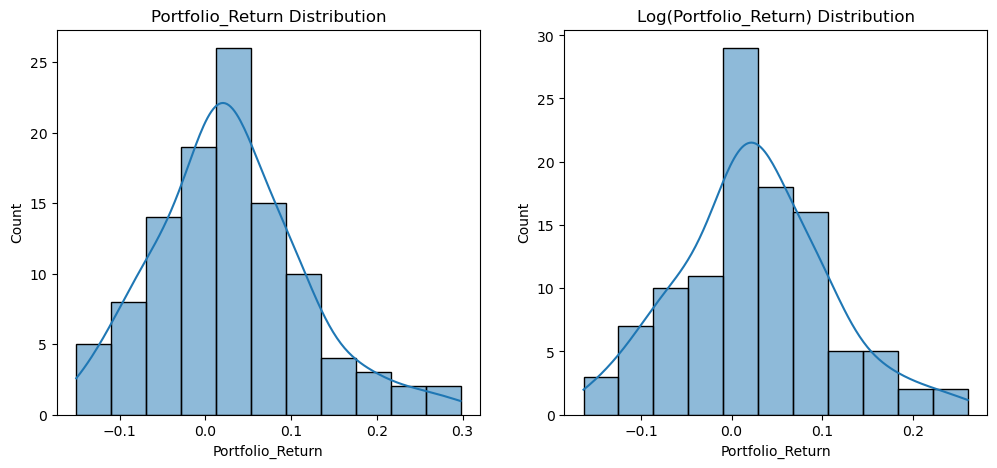

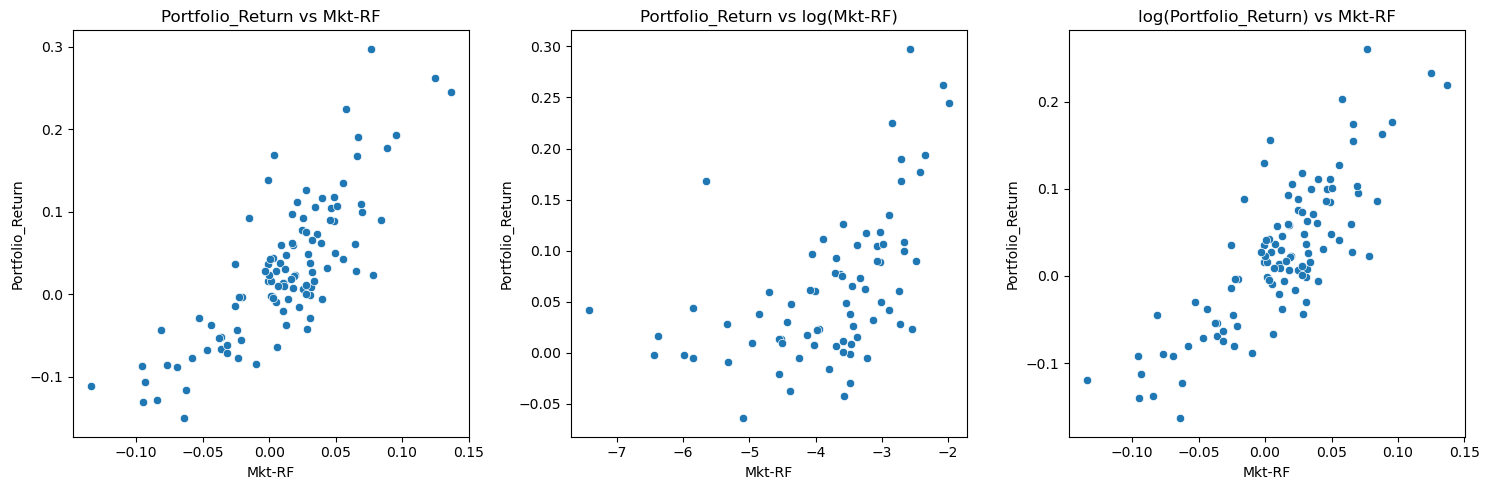

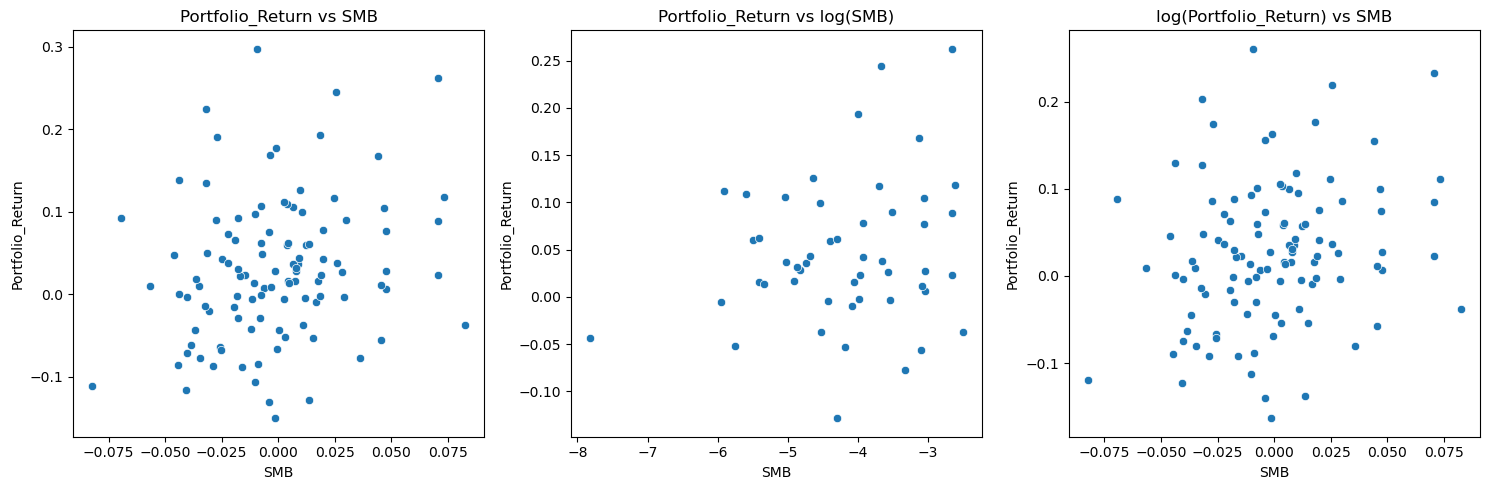

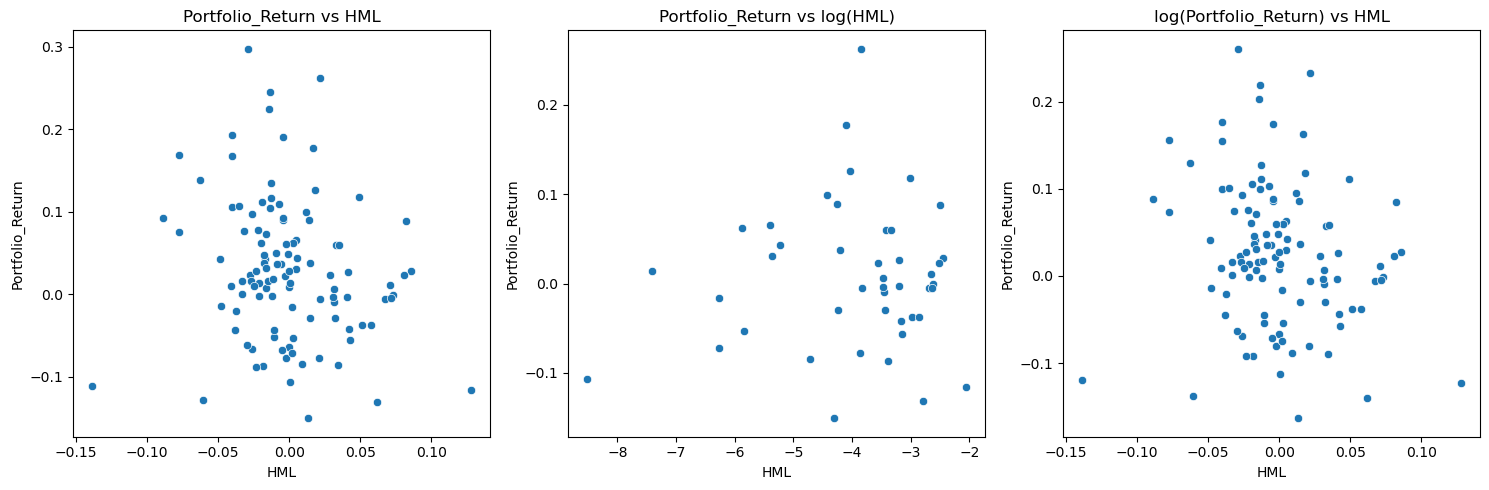

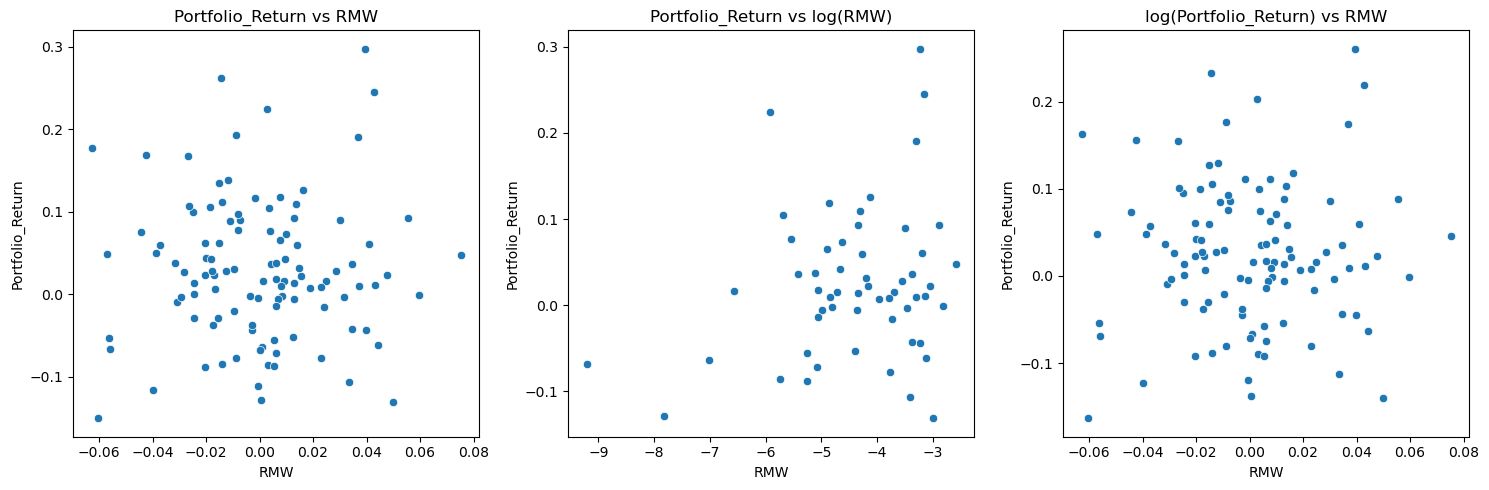

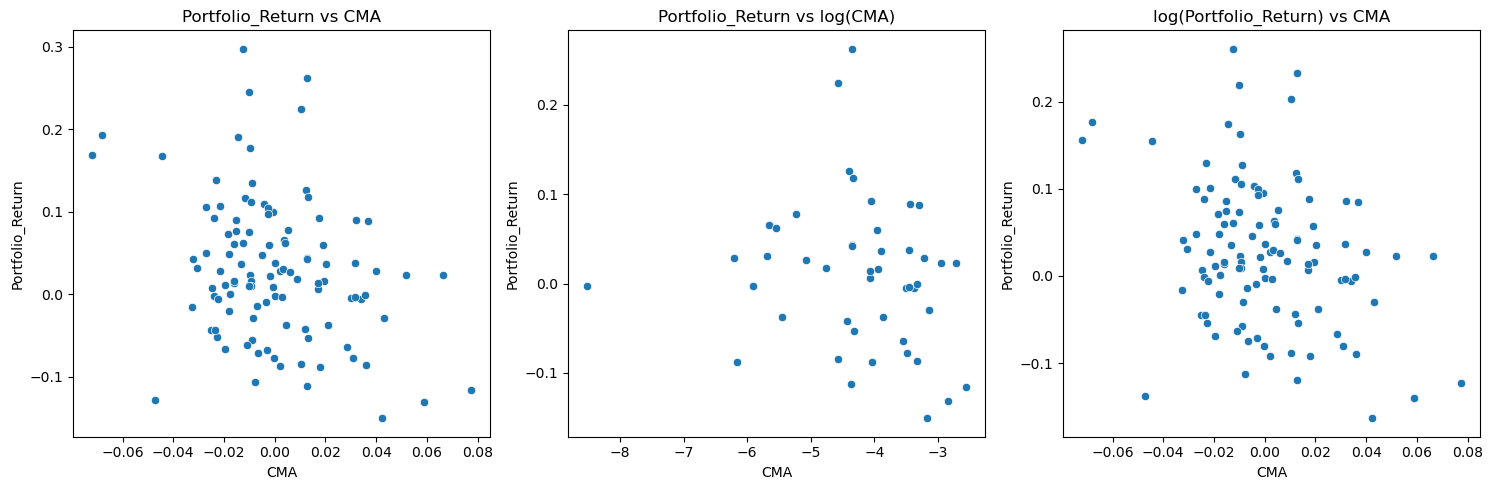

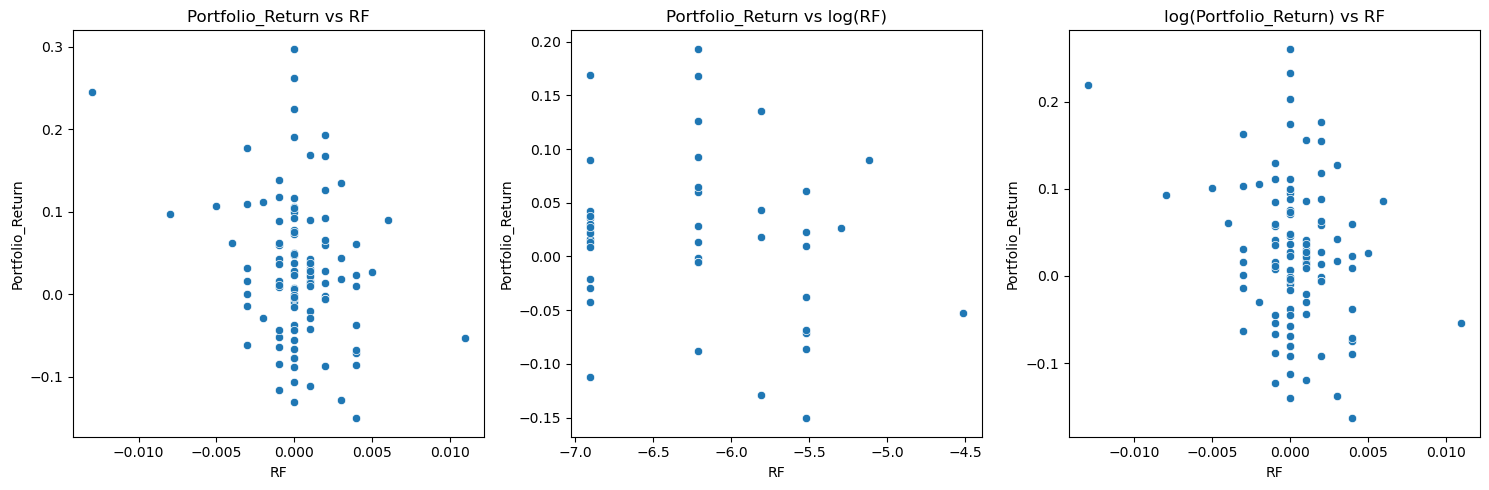

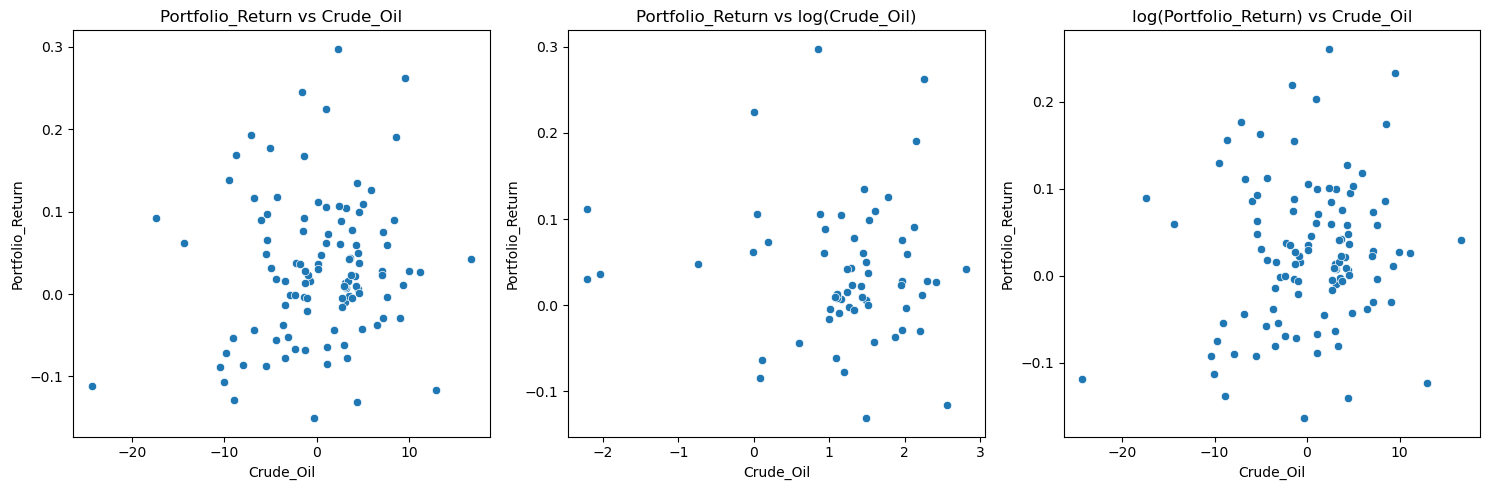

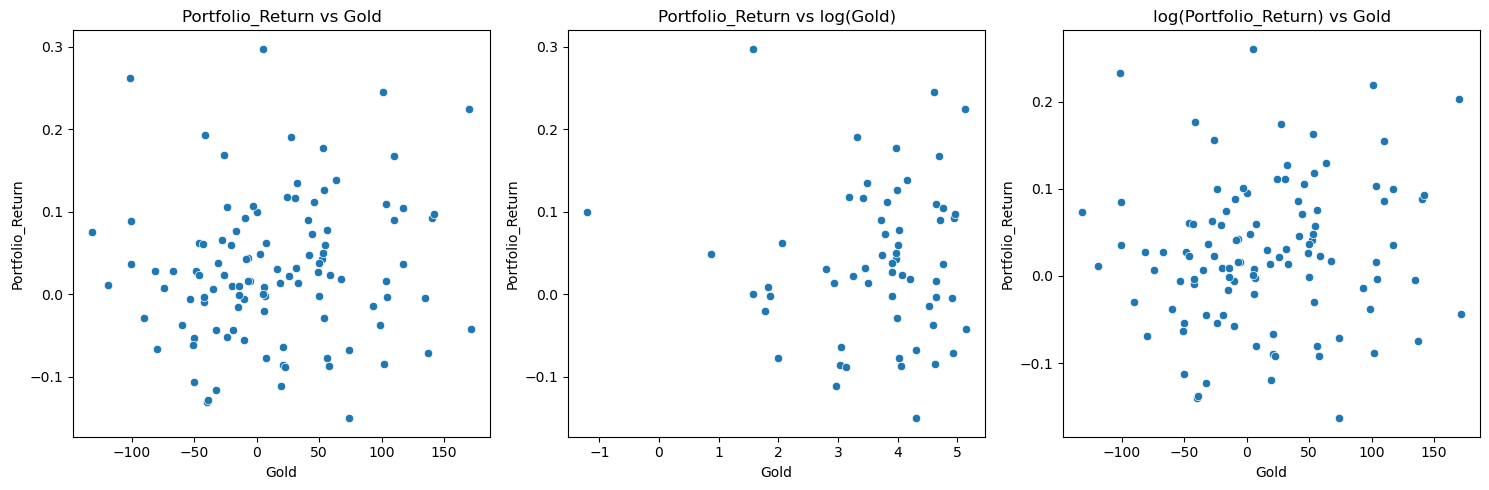

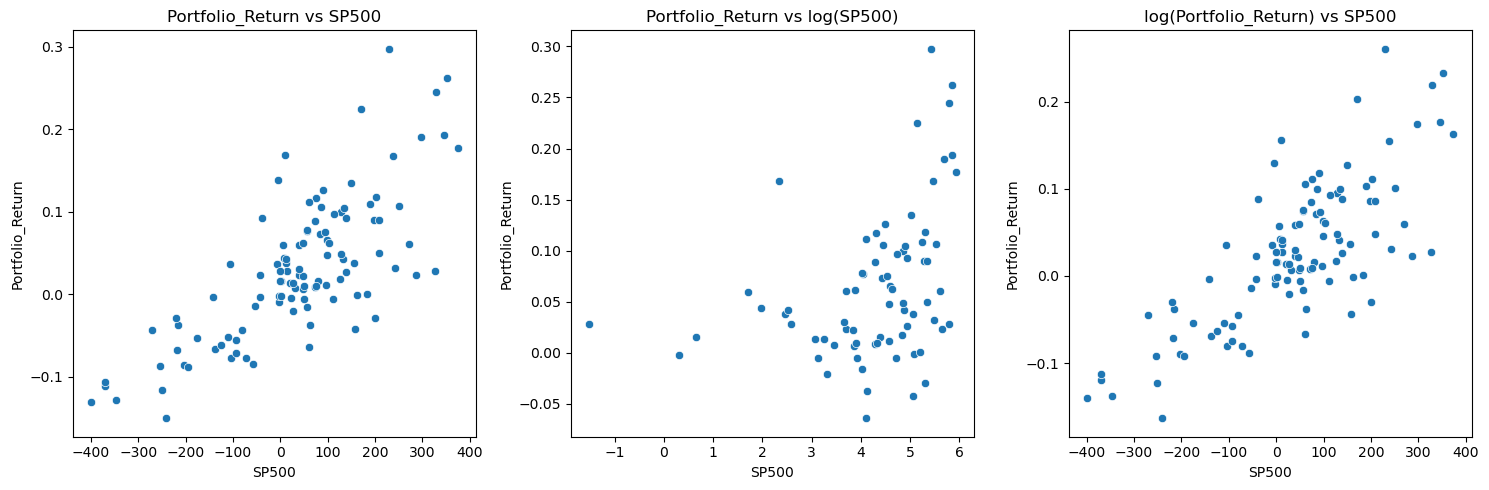

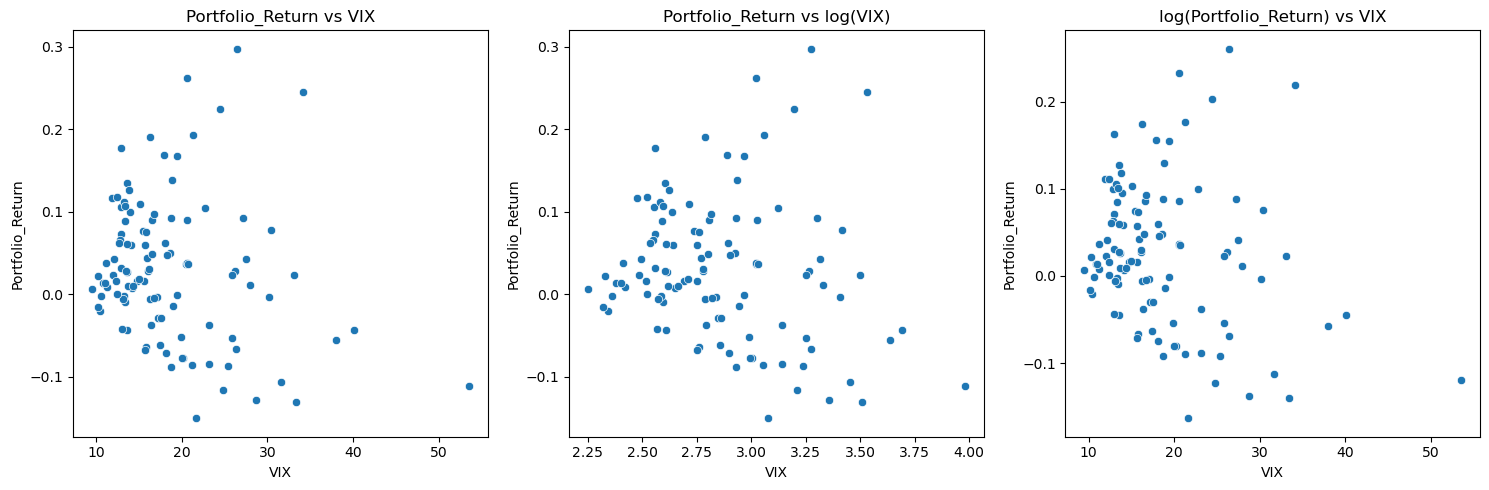

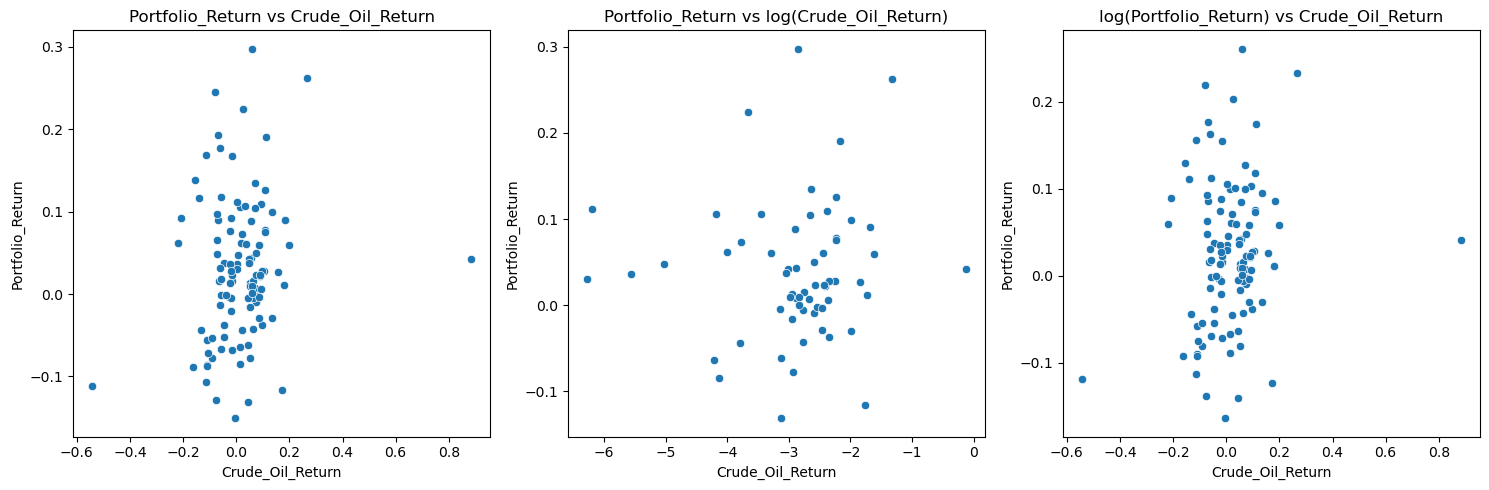

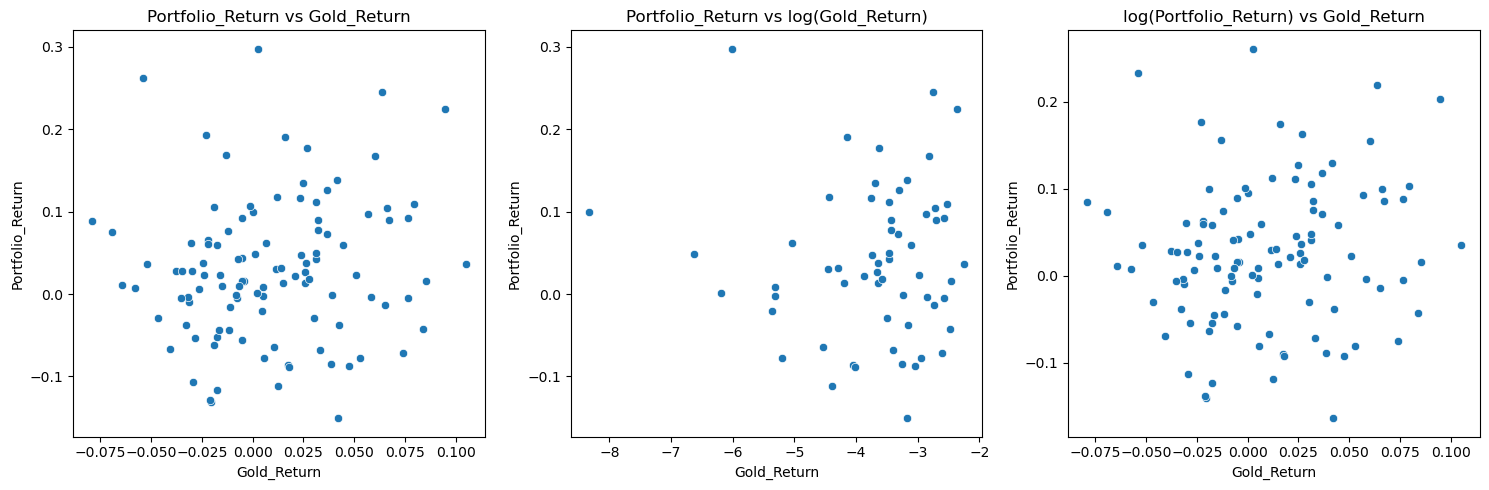

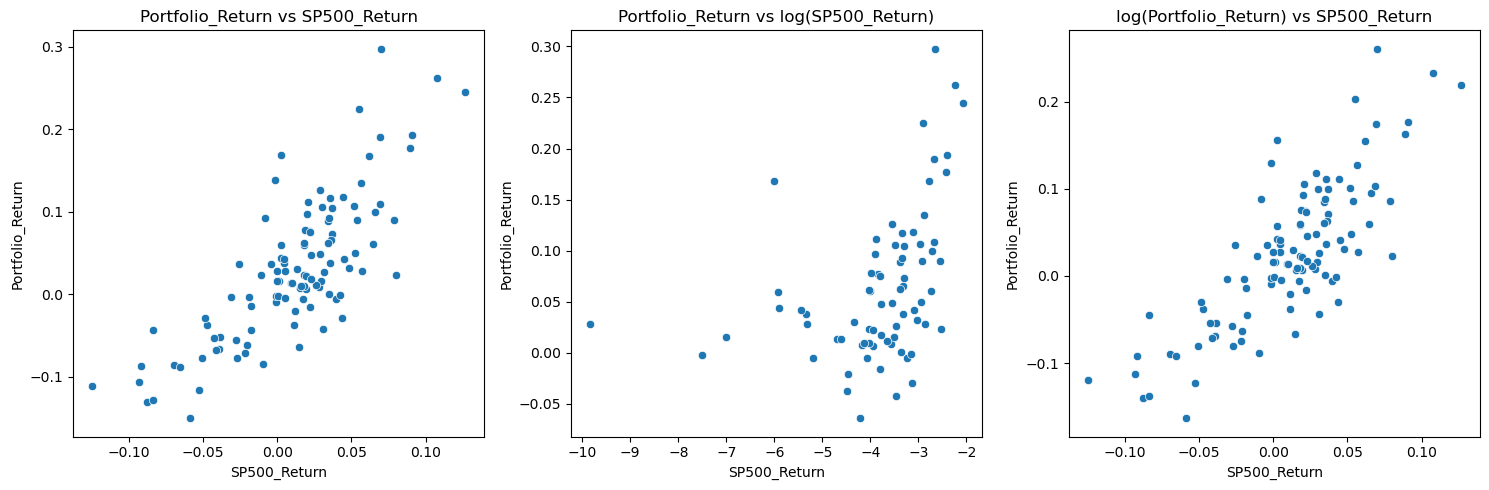

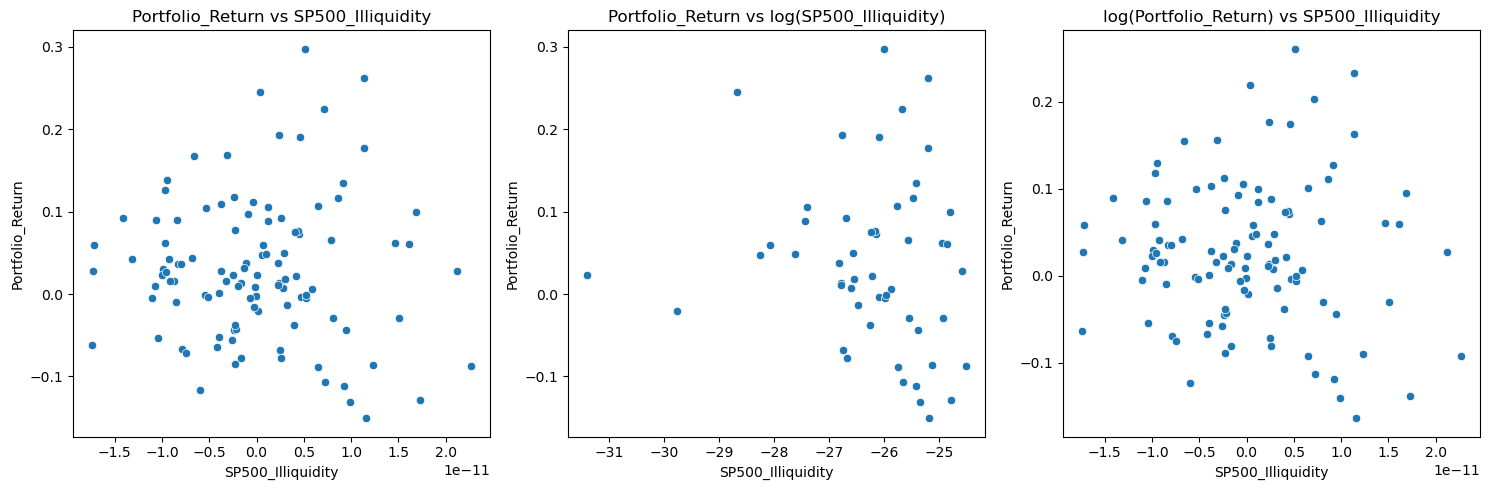

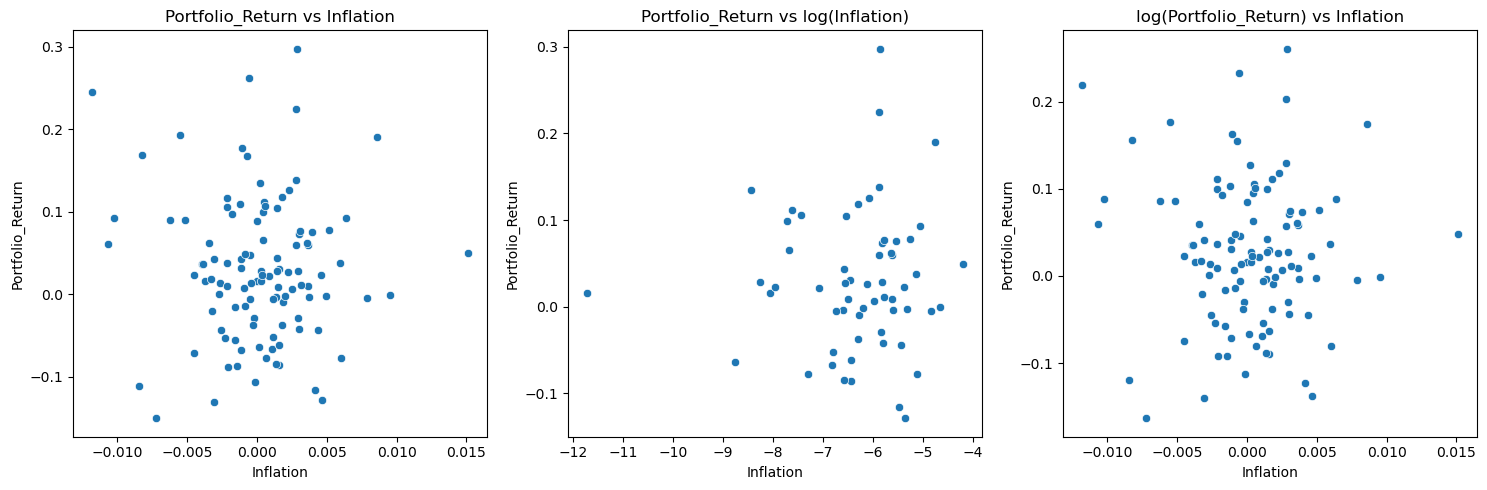

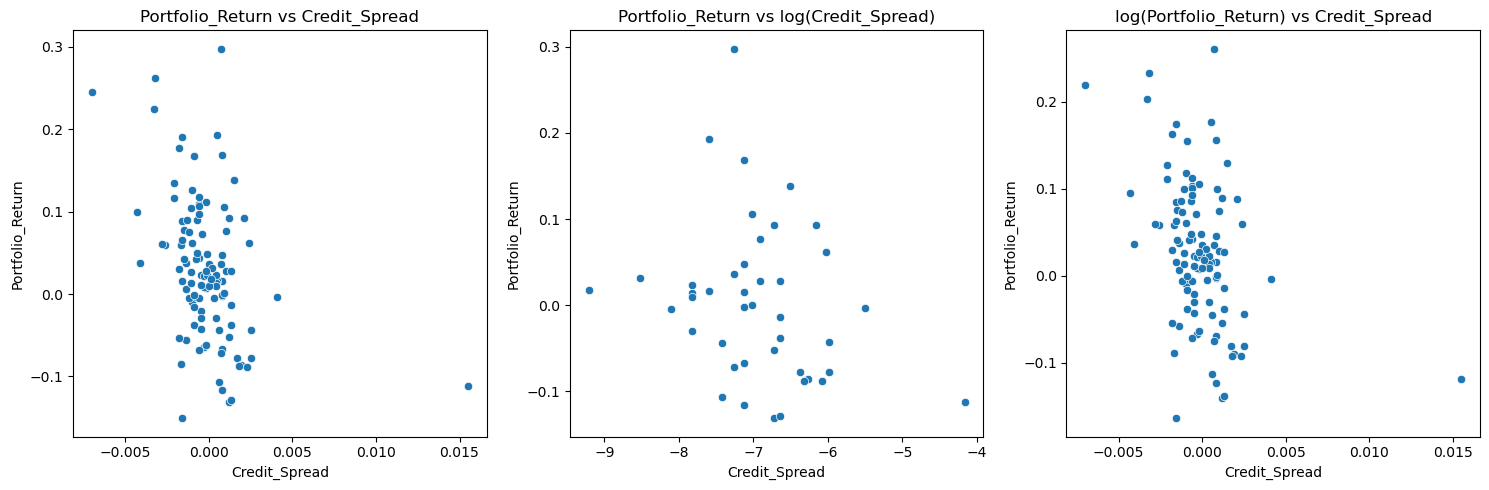

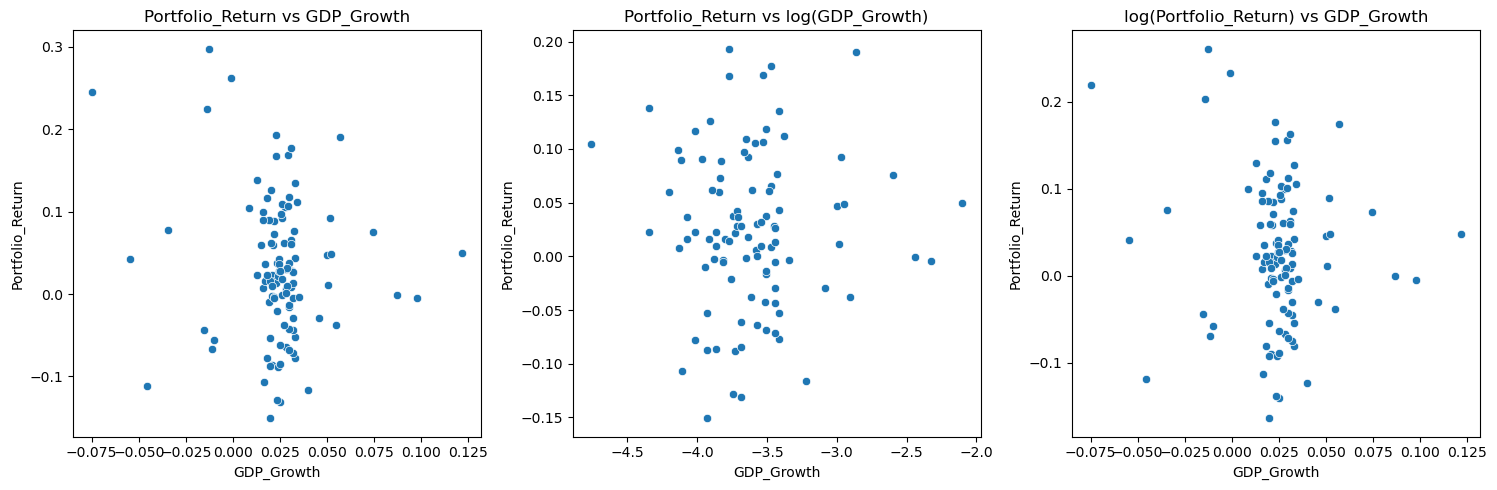

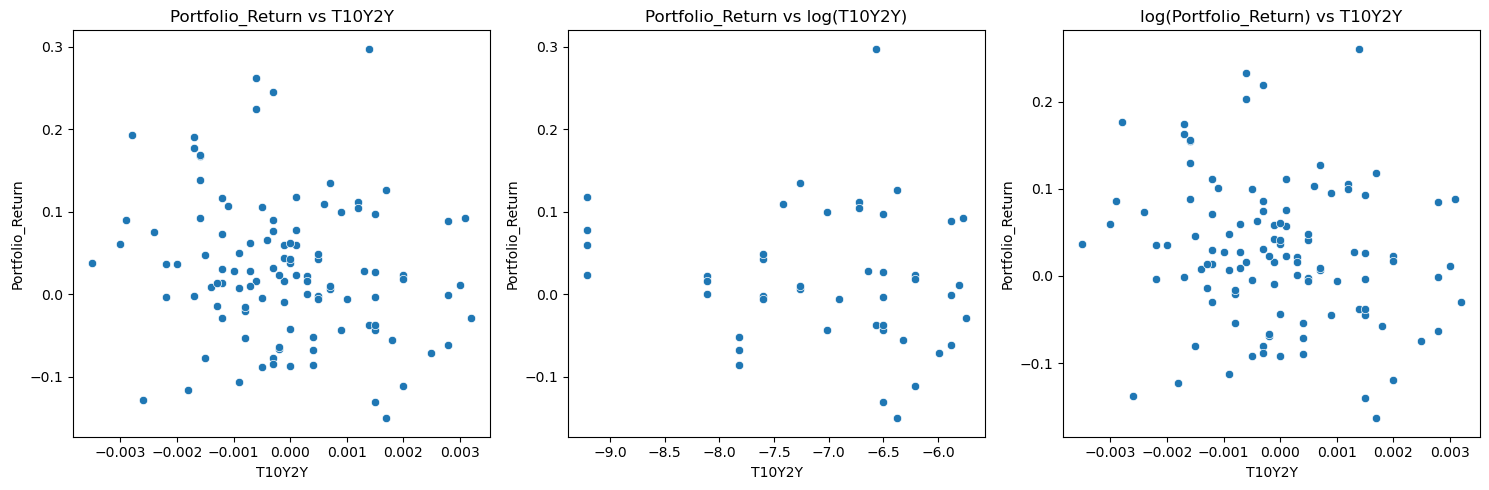

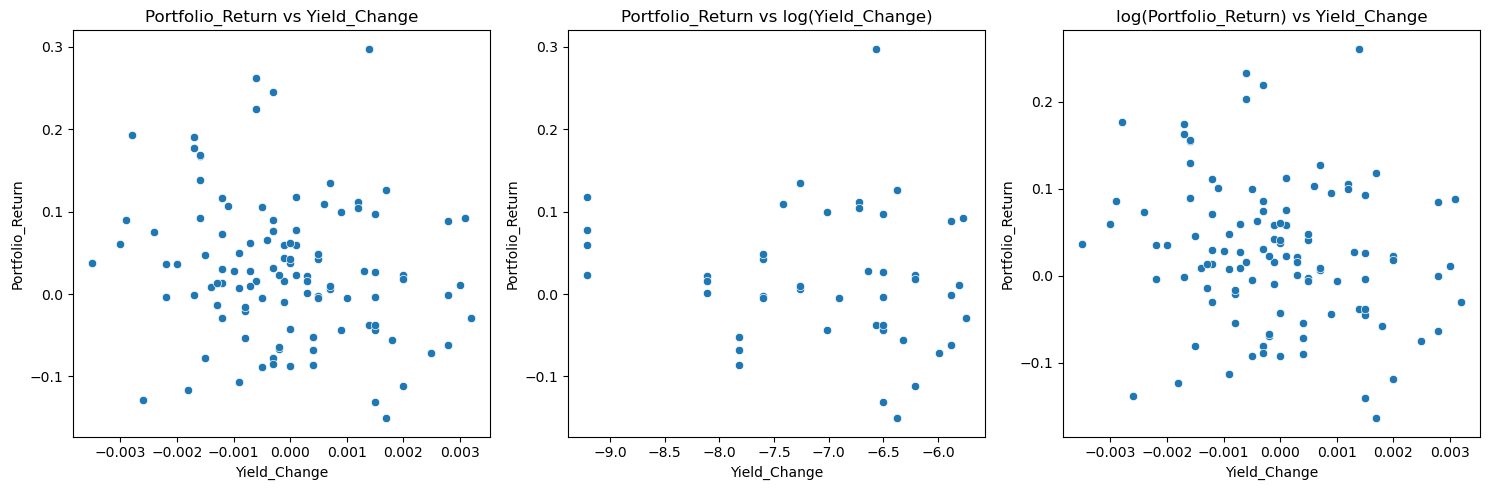

In [3]:
# Load and prepare data
df_portSummary = pd.read_csv('portfolio_summary.csv', parse_dates=['Date'], index_col='Date')
df_portDetail = pd.read_csv('portfolio_details.csv', parse_dates=['Date'], index_col='Date')
df_factor = pd.read_csv('factors.csv', parse_dates=['Date'], index_col='Date')
df = pd.merge(df_portSummary[['Portfolio_Return']], df_factor, 
              left_index=True, right_index=True, how='inner').sort_index()

stationary_df, diff_orders, dropped_cols = check_stationarity(df)
print(diff_orders)
plot_distributions(stationary_df)
    
# Prepare modeling data
data, scaler = prepare_model_data(stationary_df)

Note:

Portfolio Return Y Distribution: Exhibits right-skewness (positive skew), indicating non-normality.

Log-Transformed Log(Y): Improves normality, reduces skewness.

→ Use log transformation for modeling to better meet linear regression assumptions of normality.


##### Step 2: Modeling

In [4]:
# ===========================
# Model Evaluation
# ===========================
def evaluate_model(model, X, y, model_name="", plot_residuals=True, log=False):
    """Model evaluation with metrics and diagnostics."""
    y_pred = model.predict(X)
    if log==True:
        y_pred = np.expm1(y_pred)
    residuals = y - y_pred
    y_mean = np.mean(y)

    metrics = {
        "R²": r2_score(y, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y, y_pred)),
        "MAE": mean_absolute_error(y, y_pred),
        "Mean Residual": np.mean(residuals),
        "Residual Std": np.std(residuals)
    }
    
    print(f"\n{model_name.upper()} Evaluation")
    for name, value in metrics.items():
        print(f"{name:<25}: {value:.4f}{'%' if '%' in name else ''}")
    
    if plot_residuals:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        probplot(residuals, dist="norm", plot=axes[0])
        axes[0].set_title('Q-Q Plot of Residuals')
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
        axes[1].axhline(0, color='r', linestyle='--')
        axes[1].set_title('Residuals vs Predicted')
        plt.tight_layout()
        plt.show()
    
    return y_pred, metrics

# ===========================
# Model Implementations
# ===========================
def run_lasso(X_train, y_train, X_test, y_test, log=False):
    """Run Lasso regression with evaluation."""
    lasso = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, random_state=42).fit(X_train, y_train)
    print(f"\nOptimal alpha: {lasso.alpha_:.4f}")
    
    y_pred, metrics = evaluate_model(lasso, X_test, y_test, model_name="Lasso Regression", log=False)
    
    # Feature analysis
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lasso.coef_,
        'Abs_Coefficient': np.abs(lasso.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop Features:")
    print(coef_df.head(10))
    
    return lasso, y_pred, metrics, coef_df

def run_gradient_boosting(X_train, y_train, X_test, y_test, n_estimators=200, max_depth=3, log=False):
    """Run Gradient Boosting with evaluation."""
    gbt = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                  learning_rate=0.1, random_state=42).fit(X_train, y_train)
    
    y_pred, metrics = evaluate_model(gbt, X_test, y_test, model_name="Gradient Boosting", plot_residuals=False, log=False)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': gbt.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df.head(10))
    
    # Partial dependence plots
    top_features = importance_df['Feature'].head(3).tolist()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, feature in enumerate(top_features):
        PartialDependenceDisplay.from_estimator(gbt, X_train, [feature], ax=axes[i])
    plt.tight_layout()
    plt.show()
    
    return gbt, y_pred, metrics

def run_pca_regression(X_train, y_train, X_test, y_test, variance_threshold=0.9, log=False):
    """Perform PCA regression."""
    pca = PCA().fit(X_train)
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= variance_threshold) + 1
    
    pca = PCA(n_components=n_components)
    X_train_pca = sm.add_constant(pca.fit_transform(X_train))
    X_test_pca = sm.add_constant(pca.transform(X_test))
    
    model = sm.OLS(y_train, X_train_pca).fit()
    y_pred, metrics = evaluate_model(model, X_test_pca, y_test, model_name="PCA Regression", log=False)
    
    return model, y_pred, metrics, pca, n_components

# ===========================
# Model Comparison
# ===========================

def compare_models(model_results):
    """Compare performance metrics across different models."""
    comparison_data = {}
    
    for model_name, result in model_results.items():
        if isinstance(result, tuple):
            # For models that return (model, y_pred, metrics)
            comparison_data[model_name] = result[2]
        elif isinstance(result, dict):
            # For models that return metrics directly
            comparison_data[model_name] = result
    
    comparison_df = pd.DataFrame(comparison_data).T
    
    # Visual comparison
    metrics_to_plot = ['R²', 'RMSE', 'MAE']
    comparison_df[metrics_to_plot].plot(kind='bar', subplots=True, 
                                     layout=(1,3), figsize=(15,5),
                                     legend=False)
    plt.suptitle('Model Performance Comparison')
    plt.tight_layout()
    plt.show()
    
    return comparison_df


Optimal alpha: 0.0036

LASSO REGRESSION Evaluation
R²                       : 0.7415
RMSE                     : 0.0543
MAE                      : 0.0411
Mean Residual            : -0.0048
Residual Std             : 0.0541


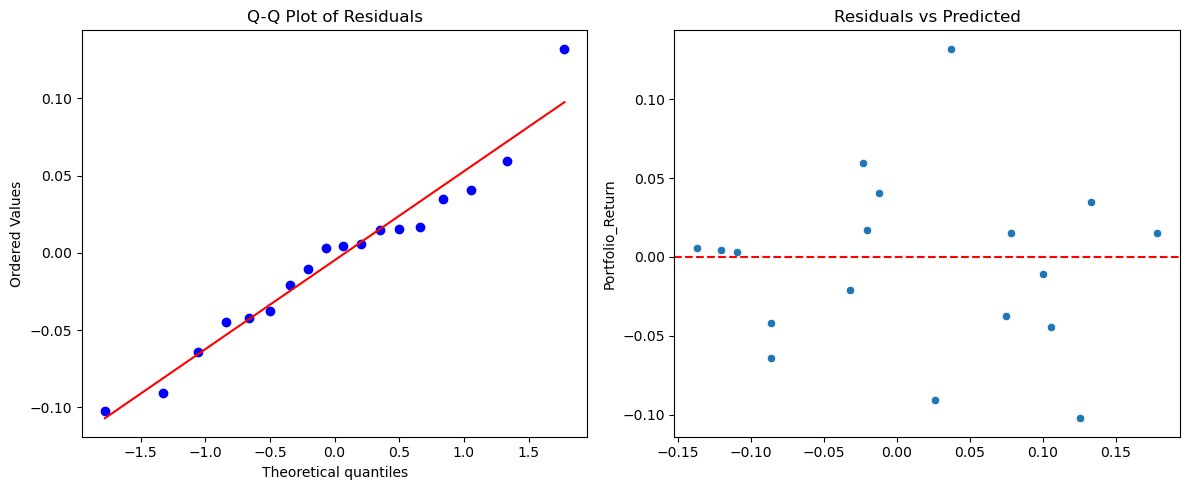


Top Features:
             Feature  Coefficient  Abs_Coefficient
0             Mkt-RF     0.070060         0.070060
2                HML    -0.009254         0.009254
9                VIX     0.006558         0.006558
6          Crude_Oil    -0.004923         0.004923
10  Crude_Oil_Return    -0.004586         0.004586
16        GDP_Growth    -0.003013         0.003013
14         Inflation     0.002376         0.002376
7               Gold     0.001832         0.001832
4                CMA     0.001801         0.001801
3                RMW     0.001346         0.001346

Optimal alpha: 0.0036

LASSO REGRESSION Evaluation
R²                       : 0.7528
RMSE                     : 0.0531
MAE                      : 0.0403
Mean Residual            : -0.0028
Residual Std             : 0.0530


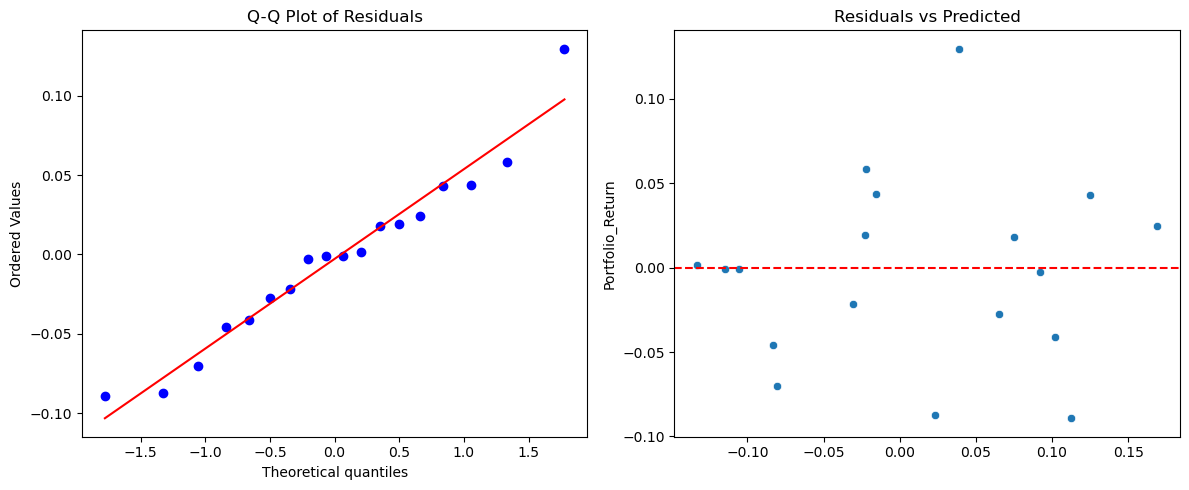


Top Features:
             Feature  Coefficient  Abs_Coefficient
0             Mkt-RF     0.065169         0.065169
2                HML    -0.008008         0.008008
6          Crude_Oil    -0.005917         0.005917
9                VIX     0.004529         0.004529
7               Gold     0.001904         0.001904
10  Crude_Oil_Return    -0.001872         0.001872
14         Inflation     0.001006         0.001006
3                RMW     0.000827         0.000827
4                CMA     0.000793         0.000793
16        GDP_Growth    -0.000733         0.000733

GRADIENT BOOSTING Evaluation
R²                       : 0.4582
RMSE                     : 0.0786
MAE                      : 0.0677
Mean Residual            : -0.0299
Residual Std             : 0.0727

Feature Importances:
             Feature  Importance
12      SP500_Return    0.624505
8              SP500    0.141285
16        GDP_Growth    0.055880
9                VIX    0.037950
6          Crude_Oil    0.021364
10 

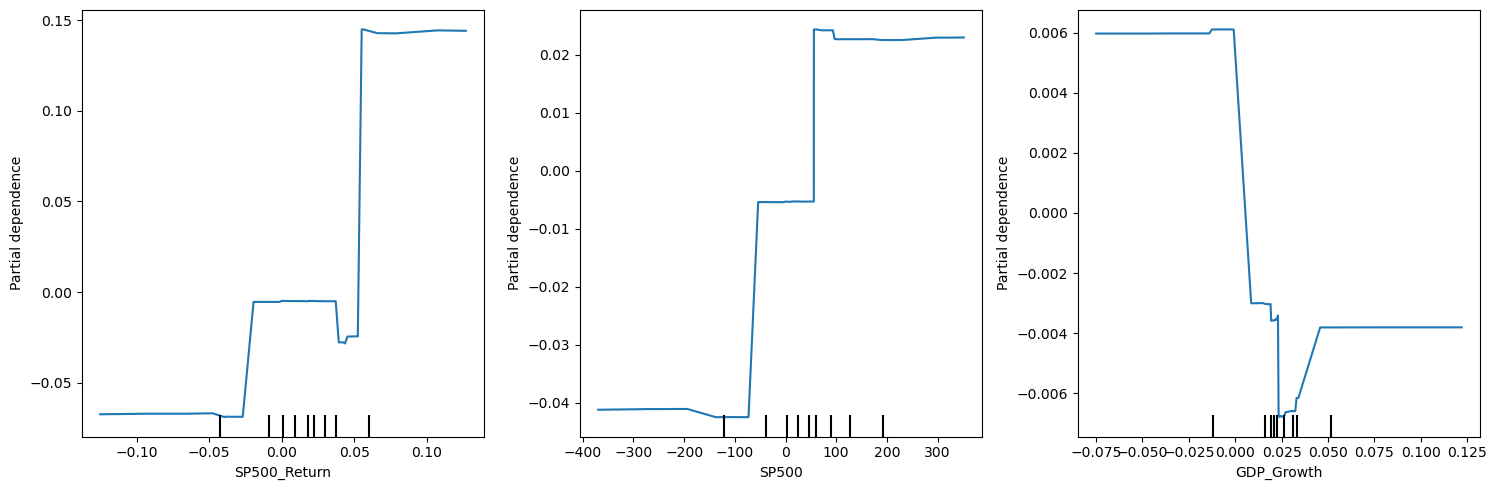


GRADIENT BOOSTING Evaluation
R²                       : 0.5788
RMSE                     : 0.0693
MAE                      : 0.0568
Mean Residual            : -0.0286
Residual Std             : 0.0631

Feature Importances:
             Feature  Importance
12      SP500_Return    0.367114
8              SP500    0.270678
0             Mkt-RF    0.126564
16        GDP_Growth    0.047137
2                HML    0.039930
6          Crude_Oil    0.022497
15     Credit_Spread    0.020320
9                VIX    0.019972
10  Crude_Oil_Return    0.019590
4                CMA    0.016974


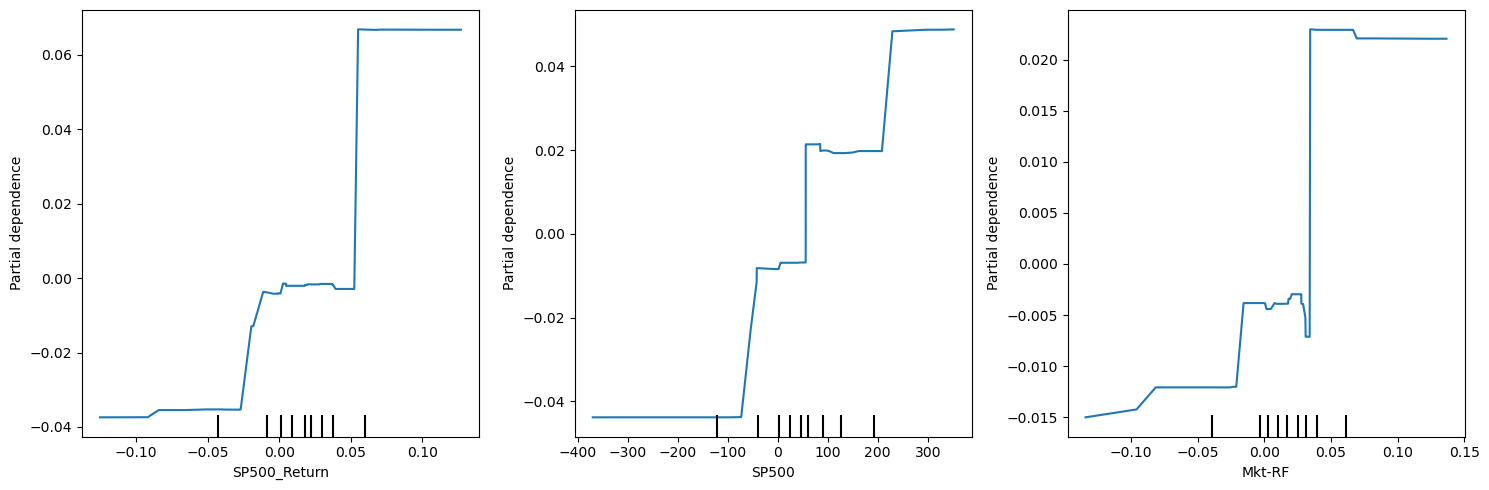


PCA REGRESSION Evaluation
R²                       : 0.6768
RMSE                     : 0.0607
MAE                      : 0.0510
Mean Residual            : 0.0108
Residual Std             : 0.0597


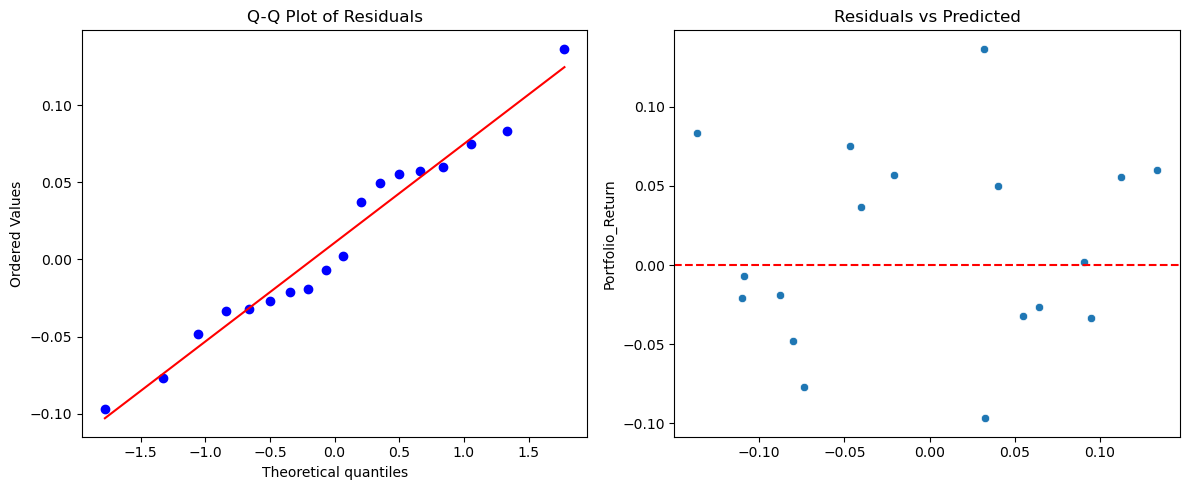


PCA REGRESSION Evaluation
R²                       : 0.6888
RMSE                     : 0.0596
MAE                      : 0.0498
Mean Residual            : 0.0128
Residual Std             : 0.0582


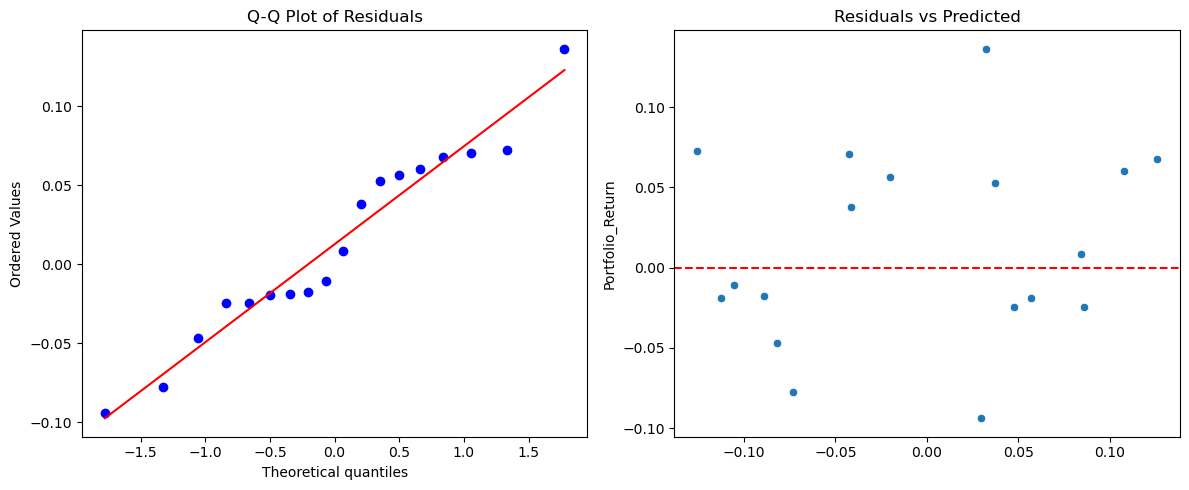

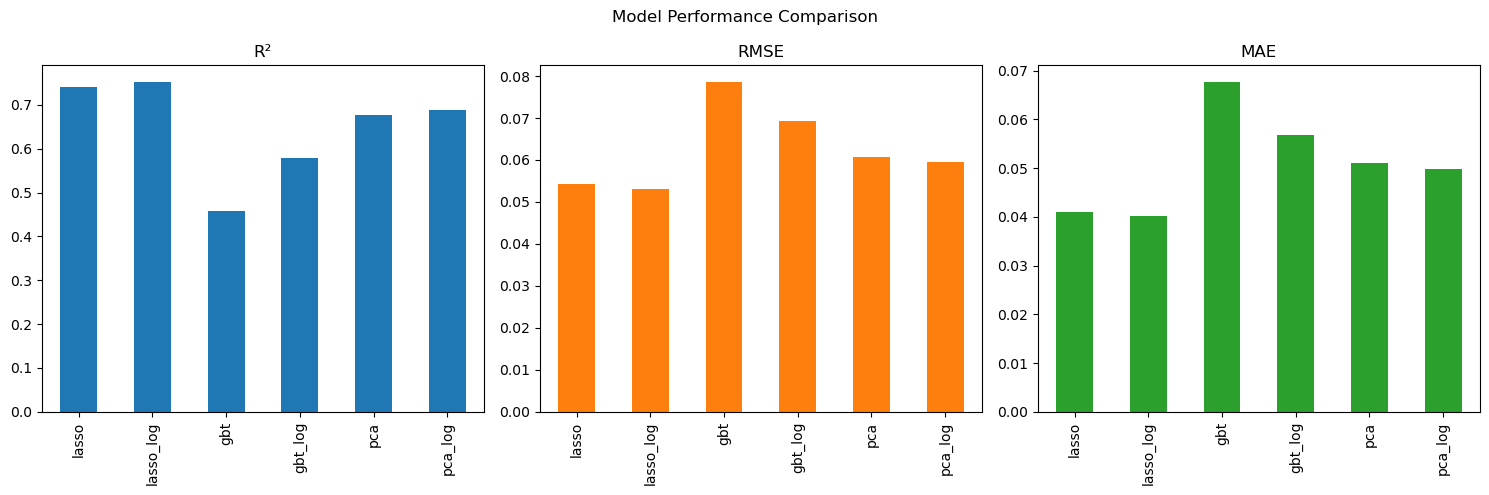


Model Performance Comparison:
                 R²      RMSE       MAE  Mean Residual
lasso      0.741452  0.054311  0.041053      -0.004786
lasso_log  0.752774  0.053108  0.040287      -0.002763
gbt        0.458152  0.078623  0.067731      -0.029873
gbt_log    0.578753  0.069324  0.056762      -0.028631
pca        0.676828  0.060720  0.050980       0.010843
pca_log    0.688780  0.059586  0.049825       0.012768


In [5]:
# ===========================
# Execution
# ===========================

# Model training and evaluation
model_results = {}
    
# Lasso models
lasso_model, lasso_y_pred, model_results['lasso'], lasso_coef_df  = run_lasso(data['X_train_scaled'], data['y_train'], 
                            data['X_test_scaled'], data['y_test'])
lassoLog_model, lassoLog_y_pred, model_results['lasso_log'], lassoLog_coef_df = run_lasso(data['X_train_scaled'], data['y_train_log'], 
                                data['X_test_scaled'], data['y_test'], log=True)
    
# Gradient Boosting models
gbt_model, gbt_y_pred, model_results['gbt'] = run_gradient_boosting(data['X_train'], data['y_train'], 
                                        data['X_test'], data['y_test'], max_depth=50)
gbtLog_model, gbtLog_y_pred, model_results['gbt_log'] = run_gradient_boosting(data['X_train'], data['y_train_log'], 
                                        data['X_test'], data['y_test'], log=True)
    
# PCA models
pca_model, pca_y_pred, model_results['pca'], pca, pca_n_componentsg = run_pca_regression(data['X_train_scaled'], data['y_train'], 
                                        data['X_test_scaled'], data['y_test'])
pcaLog_model, pcaLog_y_pred, model_results['pca_log'], pcaLog, pcaLog_n_components = run_pca_regression(data['X_train_scaled'], data['y_train_log'], 
                                            data['X_test_scaled'], data['y_test'], log=True)
    
# Model comparison
comparison_df = compare_models(model_results)
print("\nModel Performance Comparison:")
print(comparison_df[['R²', 'RMSE', 'MAE', 'Mean Residual']])

Note:
1. Best Model Selection
+ Lasso with log(y): Best model, with highest R², lowest RMSE/MAE, relatively small bias, indicating the best predictive accuracy.
+ PCA with log(y): Provides useful insights but may not ideal for prediction, since Mean Residual is relatively large.

2. Impact of Log Transformation
+ Universal improvement: All models (Lasso, GBT, PCA) perform better with log(y).
+ Most impactful for GBT: R² jumps from 0.46 → 0.58, resolving severe underfitting.

3. Systematic Bias
+ Lasso, GBT Models tend to overpredict (Mean Residual < 0).
+ PCA models tend to underpredict (Mean Residual > 0).
Underprediction is preferable in return forecasting, as overprediction can lead to excessive risk-taking.

4. Residual Analysis
+ QQ-Plot: Most residuals in the middle range follow the 45-degree line, suggesting an approximately normal distribution. However, heavy tails indicate the model does not fully capture extreme values, leading to occasional large errors.
+ Residuals vs. Predicted Plot: No clear pattern, meaning heteroscedasticity is not a major issue. However, wide residual spread suggests possible non-linearity or missing risk factors in the model.

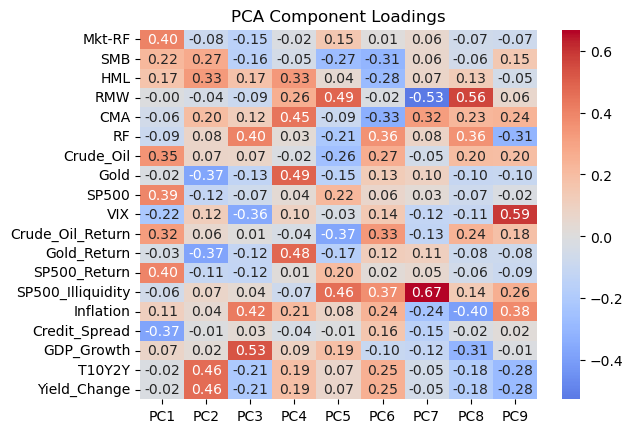

In [6]:
# PCA Loadings analysis
loadings = pd.DataFrame(pcaLog.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pcaLog_n_components)],
                        index=data['X_train_scaled'].columns)
plt.plot(figsize=(10,8))    
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('PCA Component Loadings')
plt.show()

Interpretation of PCA Components:
- PC1: Equity market movement
- PC2: Yield-gold dynamic - negative
- PC3: Economic growth expectations
- PC4: Defensive investing
- PC5: Quality-Profitability
- PC6: Inflation Sensitivity
- PC7: Liquidity risk
- PC8: Defensive Profitability
- PC9: Volatility / Market Uncertainty

##### Step 3: Portfolio Risk Decomposition

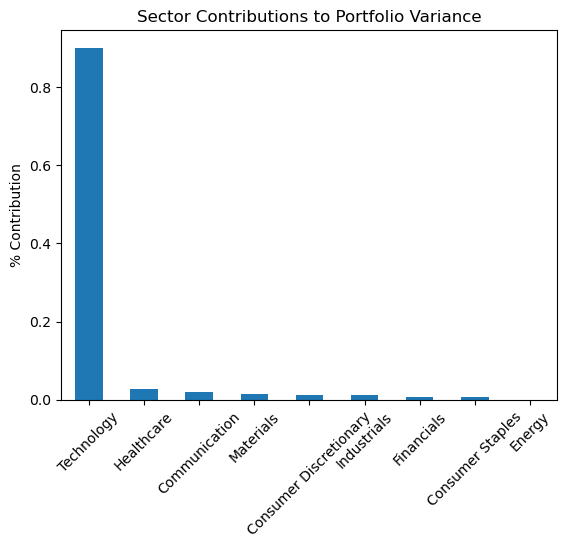

Technology                0.900281
Healthcare                0.027167
Communication             0.018915
Materials                 0.014271
Consumer Discretionary    0.013022
Industrials               0.012370
Financials                0.007327
Consumer Staples          0.006016
Energy                    0.000631
dtype: float64


In [7]:
# ===========================
# Risk by Sectors
# ===========================

# Calculate sector return
sector_weight_cols = [col for col in df_portSummary.columns if col.startswith('Sector_')]
sector_names = [col.replace('Sector_', '') for col in sector_weight_cols]

for sector in sector_names:
    # Sector value = Portfolio value * Sector weight
    df_portSummary[f'{sector}_Value'] = df_portSummary['Portfolio_Value'] * df_portSummary[f'Sector_{sector}']
    # Sector return = Percentage change in sector value
    df_portSummary[f'{sector}_Return'] = df_portSummary[f'{sector}_Value'].pct_change()
df_portSummary.dropna(inplace=True)
df_portSummary.rename(columns={
    f'Sector_{sector}': f'{sector}_Wgt' 
    for sector in sector_names
}, inplace=True)

# Ensure consistent sector order
sector_names_sorted = sorted(sector_names)
return_cols = [f'{sector}_Return' for sector in sector_names_sorted]
weight_cols = [f'{sector}_Wgt' for sector in sector_names_sorted]

backtest_portSummary = df_portSummary['2023-07-01':]
sector_returns = backtest_portSummary[return_cols]
sector_weights = backtest_portSummary[weight_cols].mean().to_numpy() # Sector weights

# Sector covariance matrix 
sector_cov_matrix = sector_returns.cov()
# Portfolio variance from sectors
sector_portfolio_variance = sector_weights.T @ sector_cov_matrix @ sector_weights
annualized_variance = sector_portfolio_variance * 12

# Sector contributions
sector_marginal_contributions = sector_weights * (sector_cov_matrix @ sector_weights)
sector_contributions = sector_marginal_contributions / sector_portfolio_variance
sector_contributions.index = [s.replace('_Return', '') for s in sector_contributions.index]
sector_contributions = sector_contributions.sort_values(ascending=False)

# Visualize decomposition
sector_contributions.plot(
    kind='bar', title='Sector Contributions to Portfolio Variance'
)
plt.ylabel('% Contribution')
plt.xticks(rotation=45)
plt.show()
print(sector_contributions)

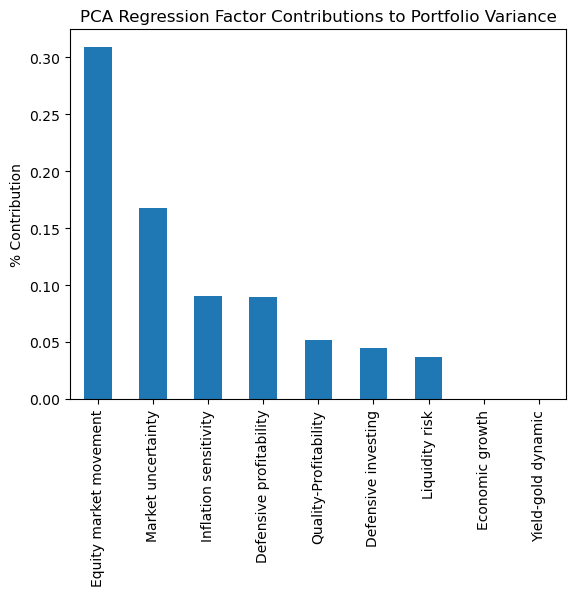

Equity market movement     0.309107
Market uncertainty         0.167444
Inflation sensitivity      0.090695
Defensive profitability    0.089759
Quality-Profitability      0.052144
Defensive investing        0.045208
Liquidity risk             0.037012
Economic growth            0.000184
Yield-gold dynamic         0.000026
dtype: float64


In [8]:
# ===========================
# Risk by Model Factors - PCA Regression
# ===========================
# Transform data
X_backtest = stationary_df['2023-06-30':].drop(columns=['Portfolio_Return'])
y_backtest = stationary_df['2023-06-30':]['Portfolio_Return']
X_backtest_scaled = scaler.transform(X_backtest)
y_backtest_log = np.log1p(y_backtest)
# PCA returns
pcaLog_backtest_returns = pcaLog.transform(X_backtest_scaled)
# Fit OLS model
X_backtest_pca = sm.add_constant(pcaLog_backtest_returns)
pcaLog_backtest_model = sm.OLS(y_backtest_log, X_backtest_pca).fit()
# PCA Betas
pcaLog_betas = pcaLog_backtest_model.params[1:] 

# Variance of each PC
pcaLog_variances = np.var(pcaLog_backtest_returns, axis=0)
# Systematic variance from PCA factors
systematic_variance = sum(pcaLog_betas**2 * pcaLog_variances)
# Total variance
residual_variance = np.var(pcaLog_backtest_model.resid)
total_variance = systematic_variance + residual_variance

# Factor contributions
pcaLog_marginal_contributions = pcaLog_betas**2 * pcaLog_variances
pcaLog_factor_risk_contributions = pcaLog_marginal_contributions / total_variance
pca_index_mapping = {
    'x1': 'Equity market movement',
    'x2': 'Yield-gold dynamic',
    'x3': 'Economic growth',
    'x4': 'Defensive investing',
    'x5': 'Quality-Profitability',
    'x6': 'Inflation sensitivity',
    'x7': 'Liquidity risk',
    'x8': 'Defensive profitability',
    'x9': 'Market uncertainty'
}
  
pcaLog_factor_risk_contributions.index = pcaLog_factor_risk_contributions.index.map(pca_index_mapping)
pcaLog_factor_risk_contributions = pcaLog_factor_risk_contributions.sort_values(ascending=False)

# Visualize decomposition
pcaLog_factor_risk_contributions.plot(
    kind='bar', title='PCA Regression Factor Contributions to Portfolio Variance'
)
plt.ylabel('% Contribution')
plt.xticks()
plt.show()
print(pcaLog_factor_risk_contributions)

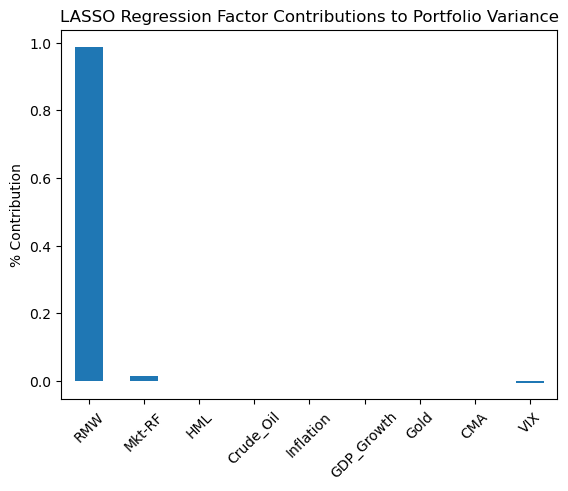

RMW           0.987916
Mkt-RF        0.015689
HML           0.001029
Crude_Oil     0.000629
Inflation     0.000034
GDP_Growth    0.000002
Gold         -0.000027
CMA          -0.000140
VIX          -0.005133
dtype: float64


In [9]:
# ===========================
# Risk by Model Factors - LASSO Regression
# ===========================
# Calculate factor return
lassoLog_factors = lassoLog_coef_df[lassoLog_coef_df['Coefficient'] != 0]['Feature'].tolist()
grouped = defaultdict(list)
for f in lassoLog_factors:
    grouped[f[:3]].append(f)

lassoLog_factors = [
    next((x for x in group if x.endswith('Return')), group[0])
    for group in grouped.values()
]
lassoLog_factor_data = data['backtest'][lassoLog_factors]
transform_factors = lassoLog_factor_data.columns[lassoLog_factor_data.columns.isin([k for k, v in diff_orders.items() if v == 1])]
lassoLog_factor_transformed = pd.merge(lassoLog_factor_data[transform_factors], df_factor[transform_factors], 
              left_index=True, right_index=True, how='inner', suffixes=('_Diff', '_Original')).sort_index()
for factor in transform_factors:
    lassoLog_factor_transformed[f'{factor}'] = lassoLog_factor_transformed[f'{factor}_Diff'] / lassoLog_factor_transformed[f'{factor}_Original'].shift(1)

lassoLog_factor_return = pd.merge(lassoLog_factor_data.drop(columns=transform_factors, errors='ignore'),
                                  lassoLog_factor_transformed[transform_factors],
                                  left_index=True, right_index=True, how='inner').sort_index()

for col in lassoLog_factors:
    new_name = f"{col}_Return"
    if lassoLog_factor_return[col].abs().max() > 1:
        lassoLog_factor_return[new_name] = lassoLog_factor_return[col].pct_change()
    else:
        lassoLog_factor_return[new_name] = lassoLog_factor_return[col]
    
    lassoLog_factor_return.drop(columns=[col], inplace=True)
lassoLog_factor_return.dropna(inplace=True)

# Factor beta
lassoLog_betas = lassoLog_coef_df.set_index('Feature').loc[lassoLog_factors]['Coefficient'].values
# Factor covariance matrix
lassoLog_factor_cov_matrix = lassoLog_factor_return.cov()
# Portfolio variance from factors
lassoLog_portfolio_variance = lassoLog_betas.T @ lassoLog_factor_cov_matrix @ lassoLog_betas

# Factor contributions
lassoLog_marginal_contributions = lassoLog_betas * (lassoLog_factor_cov_matrix @ lassoLog_betas)
LassoLog_factor_risk_contributions = lassoLog_marginal_contributions / lassoLog_portfolio_variance
LassoLog_factor_risk_contributions.index = [s.replace('_Return', '') for s in LassoLog_factor_risk_contributions.index]
LassoLog_factor_risk_contributions = LassoLog_factor_risk_contributions.sort_values(ascending=False)

# Visualize decomposition
LassoLog_factor_risk_contributions.plot(
    kind='bar', title='LASSO Regression Factor Contributions to Portfolio Variance'
)
plt.ylabel('% Contribution')
plt.xticks(rotation=45)
plt.show()
print(LassoLog_factor_risk_contributions)

##### Step 4: Backtest VaR

In [10]:

y_training = stationary_df[:'2023-07-01']['Portfolio_Return']
y_backtest = data['backtest']['Portfolio_Return']
X_backtest = data['backtest'].drop(columns=['Portfolio_Return'])
X_backtest_scaled = scaler.transform(X_backtest)

# ==============================================
# ARIMA + GARCH VaR
# ==============================================
# Fit ARIMA
arima = ARIMA(y_training, order=(1, 0, 1)).fit()
arima_resid = arima.resid

# Check for ARCH effects
arch_test_stat, arch_test_p_value, _, _ = het_arch(arima_resid)
if arch_test_p_value < 0.05:
    print("ARCH effects detected. Use ARIMA+GARCH.")
    garch = arch_model(arima_resid, vol='GARCH', p=1, q=1, dist='t')
    garch_result = garch.fit(disp='off')
else:
    print("No significant ARCH effects. Use ARIMA")

# Walk-forward forecast for VaR
forecasts = []
rolling_y = y_training.copy()

for i in range(len(y_backtest)):
    arima = ARIMA(rolling_y, order=(1, 0, 1))
    arima_result = arima.fit()
    
    arima_mean_forecast = arima_result.forecast(steps=1).iloc[0]
    arima_resid = arima_result.resid
    garch = arch_model(arima_resid, vol='GARCH', p=1, q=1, dist='t')
    garch_result = garch.fit(disp='off')
    vol_forecast = np.sqrt(garch_result.forecast(horizon=1, reindex=False).variance.iloc[-1, 0])
    
    df_t = garch_result.params["nu"]
    t_quantile = t.ppf(0.05, df=df_t) 
    var_95 = arima_mean_forecast + vol_forecast * t_quantile
    
    forecasts.append(var_95)
    
    rolling_y = pd.concat([rolling_y, y_backtest.iloc[[i]]])

garch_pred_var = pd.Series(forecasts, index=y_backtest.index)
garch_var_violations = (y_backtest < garch_pred_var).sum()
garch_uc_pvalue = binom_test(garch_var_violations, n=len(y_backtest), p=0.05)

# ==============================================
# Historical VaR
# ==============================================
def historical_var(returns, window=12, alpha=0.05):
    return returns.rolling(window).quantile(alpha)

hist_pred_var = historical_var(pd.concat([y_training, y_backtest]), window=12)[len(y_training):]
hist_var_violations = (y_backtest < hist_pred_var).sum()
hist_uc_pvalue = binom_test(hist_var_violations, n=len(y_backtest), p=0.05)

# ==============================================
# LASSO Regression VaR 
# ==============================================
# Predict returns on backtest set
lassoLog_y_pred_backtest = []
for i in range(len(y_backtest)):    
    y_pred = lassoLog_model.predict(X_backtest_scaled[[i]])[0]
    lassoLog_y_pred_backtest.append(y_pred)
lassoLog_y_pred_backtest_unlog = np.expm1(lassoLog_y_pred_backtest)

# Estimate 5th percentile of residuals from training
lassoLog_y_pred_unlog = np.expm1(lassoLog_y_pred)  # From training set
lassoLog_residuals = data['y_test'] - lassoLog_y_pred_unlog
lassoLog_var_adjustment = np.quantile(lassoLog_residuals, 0.05)

# Construct predicted VaR
lassoLog_pred_var = lassoLog_y_pred_backtest_unlog + lassoLog_var_adjustment
lassoLog_var_violations = (y_backtest < lassoLog_pred_var).sum()
lassoLog_uc_pvalue = binom_test(lassoLog_var_violations, n=len(y_backtest), p=0.05)

ARCH effects detected. Use ARIMA+GARCH.


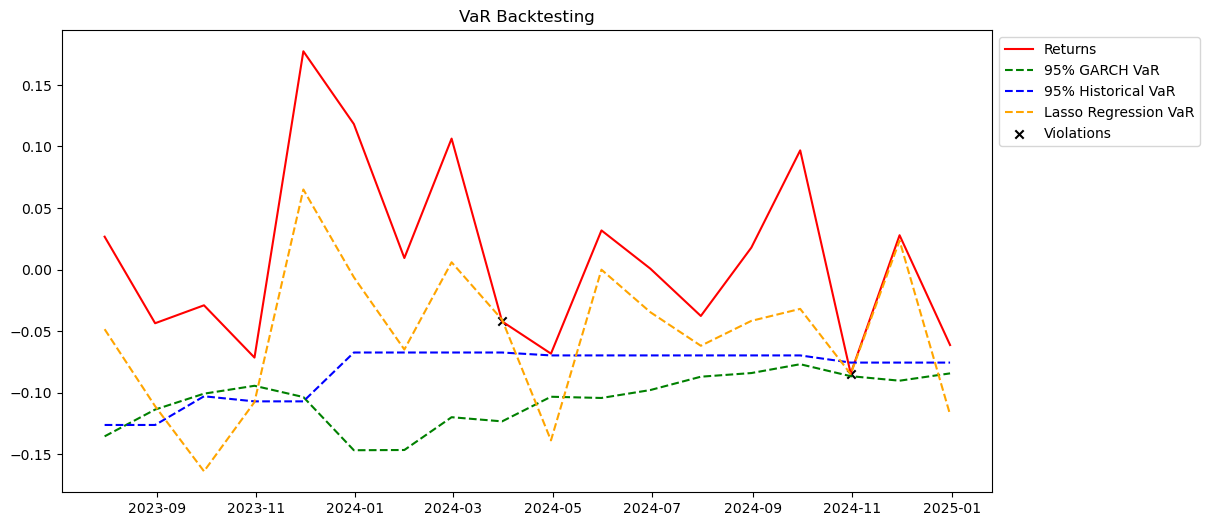

,Model,Violations,Violation Rate,UC p-value,Status
0,GARCH VaR,0/18,0.00%,1.0000,Valid
1,Historical VaR,1/18,5.56%,0.6028,Valid
2,LASSO Regression VaR,1/18,5.56%,0.6028,Valid


In [11]:
# ===========================
# Compare VaR Estimates
# ===========================
# Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_backtest.index, y_backtest, color='red', label='Returns')
plt.plot(y_backtest.index, garch_pred_var, color='green', linestyle='--', label='95% GARCH VaR')
plt.plot(y_backtest.index, hist_pred_var, color='blue', linestyle='--', label='95% Historical VaR')
plt.plot(y_backtest.index, lassoLog_pred_var, color='orange', linestyle='--', label='Lasso Regression VaR')
plt.scatter(y_backtest[y_backtest < garch_pred_var].index, 
            y_backtest[y_backtest < garch_pred_var], 
            color='k', marker='x', label='Violations')
plt.scatter(y_backtest[y_backtest < hist_pred_var].index,
            y_backtest[y_backtest < hist_pred_var],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < lassoLog_pred_var].index,
            y_backtest[y_backtest < lassoLog_pred_var],
            color='k', marker='x')
plt.title('VaR Backtesting')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Create VaR Summary DataFrame
var_results_df = pd.DataFrame({
    'Model': ['GARCH VaR', 'Historical VaR', 'LASSO Regression VaR'],
    'Violations': [f"{garch_var_violations}/{len(y_backtest)}", 
                   f"{hist_var_violations}/{len(y_backtest)}", 
                   f"{lassoLog_var_violations}/{len(y_backtest)}"],
    'Violation Rate': [garch_var_violations/len(y_backtest), 
                      hist_var_violations/len(y_backtest), 
                      lassoLog_var_violations/len(y_backtest)],
    'UC p-value': [garch_uc_pvalue, hist_uc_pvalue, lassoLog_uc_pvalue],
    'Status': ['Valid' if p > 0.05 else 'Invalid' 
              for p in [garch_uc_pvalue, hist_uc_pvalue, lassoLog_uc_pvalue]]
})

var_results_df['Violation Rate'] = var_results_df['Violation Rate'].map('{:.2%}'.format)
var_results_df['UC p-value'] = var_results_df['UC p-value'].map('{:.4f}'.format)
var_results_df

Note:
All three models are statistically valid, meaning they are performing as expected.

GARCH VaR: This model is relatively conservative, meaning it always accounts for enough risk, but it might be too strict, leading to holding more capital than needed.

LASSO Regression VaR and Historical VaR: Both models have a violation rate of about 5%, which is expected for a 95% confidence level. LASSO Regression is less conservative than Historical VaR, meaning it predicts lower risk and could result in using less capital. Historical VaR, however, may overestimate risk compared to LASSO.